In [1]:
# Francisco Dominguez Mateos
# 06/08/2020
# SIREN 
# jax version of this colab
#       https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb#scrollTo=2U1tvVb3sjd9

In [11]:
import time
import numpy as onp
import jax.numpy as np
from jax import jacrev, grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import skimage
from PIL import Image
import cv2
print("OpenCV v",cv2.__version__)

ImportError: /home/francisco/anaconda3/envs/jax_gpu/lib/python3.7/site-packages/../../././libgnutls.so.30: symbol nettle_rsa_pss_sha256_verify_digest, version HOGWEED_4 not defined in file libhogweed.so.4 with link time reference

In [10]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [np.linspace(-1, 1, num=sidelen)])
    mgrid = np.dstack(np.meshgrid(*tensors))
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [4]:
get_mgrid(2)

DeviceArray([[-1., -1.],
             [ 1., -1.],
             [-1.,  1.],
             [ 1.,  1.]], dtype=float32)

In [5]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [6]:
def Siren(s=[1000]*5,omega_0=30.0):
    def init_fun(key,input_shape):
        """ Initialize the weights of all layers of a linear layer network """
        sizes=[input_shape[-1]]+s
        print(sizes)
        keys = random.split(key, len(sizes))
        print(len(keys))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, rng):
            scale=np.sqrt(6.0/float(m))/omega_0
            w_key, b_key = random.split(rng)
            return scale * random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        # actually they are pairs plus the random key
        pairs=list(zip(sizes[:-1], sizes[1:], keys))
        params=[initialize_layer(m, n, k) for m, n, k in pairs[:]]
        # The scale of first layes is different
        m,n,k=pairs[0]
        w_key, b_key = random.split(k)
        scale=1.0/float(m)
        print("scale",m,n,scale)
        params[0]=scale*random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        output_shape =  input_shape[:-1] + (sizes[-1],)
        return (output_shape,params)
    def apply_fun(params, inputs, **kwargs):
        """ Compute the forward pass for each example individually """
        activations = inputs
        # Loop over the Siren hidden layers
        for w, b in params[:-1]:
            linear = np.dot(w,activations)+b
            activations=np.sin(omega_0*linear)
        w,b=params[-1]
        linear= np.dot(w,activations)+b
        #return activations#.reshape(())
        return linear#.reshape(())
    return init_fun, apply_fun

In [7]:
# This function is needed because grad need a funtion with scalar as output, that is what a.reshape(()) does
# and Siren return a 1D np.array that grad doesn't like
def net_pre_grad(params,x):
    a=net(params,x)
    return a.reshape(())
def laplace(params,x):
    jac=jacrev(net_grad,1)
    return np.trace(jac(params,x))

In [8]:
init,net=Siren([256]*3+[1])
net_grad=grad(net_pre_grad,argnums=1)
net_lapl=laplace

input_shape=(-1,2)
output_shape,params=init(rng,input_shape)
print(output_shape)
for l in params:
    print(l[0].shape,l[1].shape)

[2, 256, 256, 256, 1]
5
scale 2 256 0.5
(-1, 1)
(256, 2) (256,)
(256, 256) (256,)
(256, 256) (256,)
(1, 256) (1,)


In [9]:
# Make a batched version of the `net` function
batch_net      = vmap(net     , in_axes=(None, 0), out_axes=0)
batch_net_grad = vmap(net_grad, in_axes=(None, 0), out_axes=0)
batch_net_lapl = vmap(net_lapl, in_axes=(None, 0), out_axes=0)

In [10]:
def get_cameraman_tensor(sidelength):
    img_pil = Image.fromarray(skimage.data.camera())  
    img_np=onp.array(img_pil)
    img_sz=cv2.resize(img_np,(sidelength,sidelength))
    img=img_sz/255*2-1
    return img

In [11]:
sidelength=128
img=get_cameraman_tensor(sidelength)
targets=img.reshape(-1,1)
inputs=get_mgrid(sidelength)
print(inputs.shape)
print(targets.shape)

(16384, 2)
(16384, 1)


In [12]:
@jit
def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = batch_net(params, inputs)
    return np.mean((preds - targets)**2)
@jit
def accuracy(params,inputs,targets):
    return mse_loss(params,inputs,targets)
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [13]:
# Defining an optimizer in Jax
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [14]:
num_epochs = 50
steps_til_summary = 10

In [15]:
def run_training_loop(num_epochs, opt_state):
    global params
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss = update(params, inputs,targets, opt_state)
        if(epoch %steps_til_summary ==0):
            epoch_time = time.time() - start_time
            print("Epoch {} | T: {:0.3f} | loss: {:0.4f}".format(epoch+1, epoch_time,loss))
            img_pred =batch_net(params,inputs)
            img_grad =batch_net_grad(params,inputs)
            img_lapl =batch_net_lapl(params,inputs)
            
            fig, axes = plt.subplots(1,3, figsize=(18,6))
            axes[0].imshow(img_pred.reshape((sidelength,sidelength)))
            axes[1].imshow(np.linalg.norm(img_grad,axis=1).reshape((sidelength,sidelength)))
            axes[2].imshow(img_lapl.reshape((sidelength,sidelength)))
            plt.show()

    return opt_state, train_loss, log_acc_train, log_acc_test

Epoch 1 | T: 1.549 | loss: 0.2399


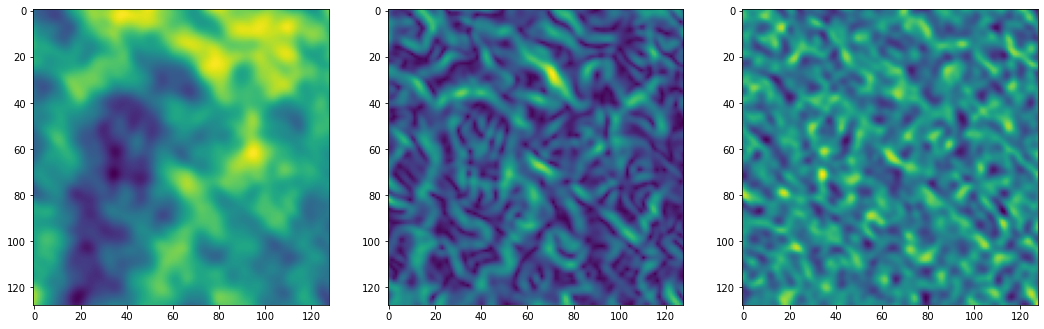

Epoch 11 | T: 0.001 | loss: 0.0556


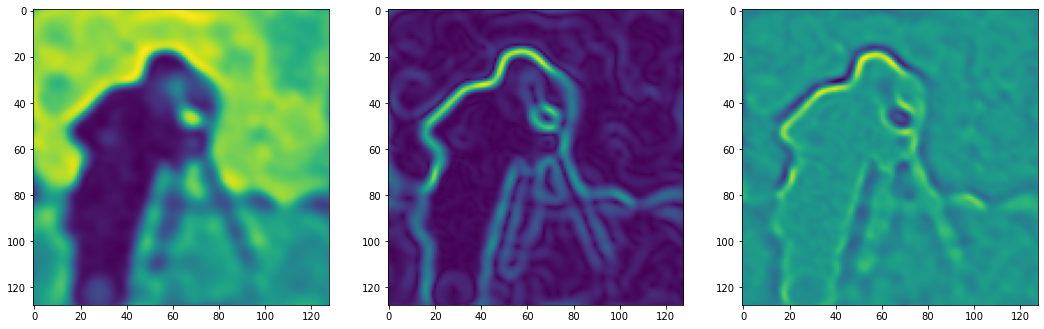

Epoch 21 | T: 0.001 | loss: 0.0312


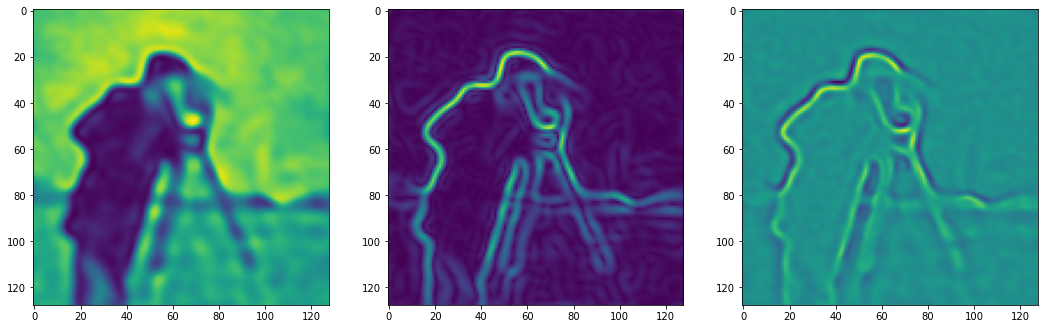

Epoch 31 | T: 0.001 | loss: 0.0242


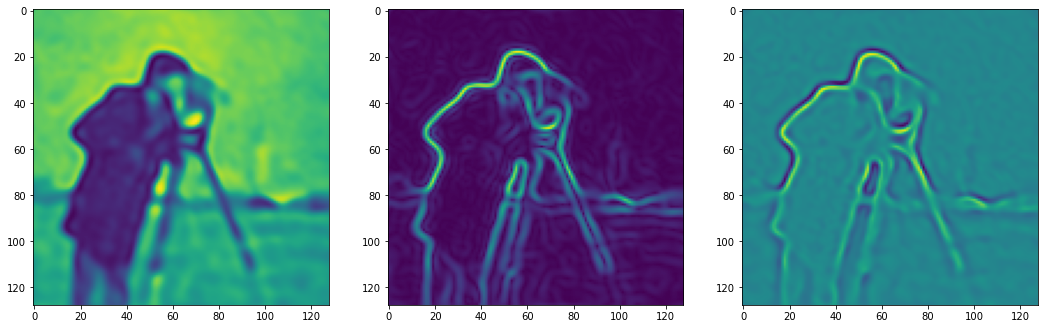

Epoch 41 | T: 0.001 | loss: 0.0206


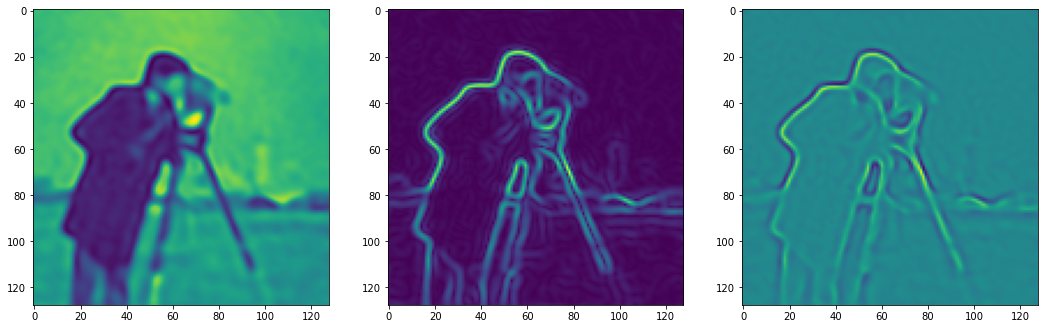

In [16]:
opt_state, train_loss, train_log, test_log =run_training_loop(num_epochs,opt_state)